### import useful packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

%matplotlib inline

### load data

In [2]:
data_dir = './data/'
ratings = pd.read_csv(data_dir+"ratings.dat", 
                      sep = "::", 
                      engine='python', 
                      header=None, 
                      names=['UserID','MovieID','Rating','Timestamp'])
users = pd.read_csv(data_dir+"users.dat", 
                      sep = "::", 
                      engine='python', 
                      header=None, 
                      names=['UserID','Gender','Age','Occupation','Zip-code'])
movies = pd.read_csv(data_dir+"movies.dat", 
                      sep = "::", 
                      engine='python', 
                      header=None, 
                      names=['MovieID','Title','Genres'])

### data preprocessing

In [3]:
# transform user ID 
le = preprocessing.LabelEncoder()
le.fit(users.UserID)
le.classes_
users.UserID = le.transform(users.UserID) 
ratings.UserID = le.transform(ratings.UserID)

# transform movie ID
le = preprocessing.LabelEncoder()
le.fit(movies.MovieID)
le.classes_
movies.MovieID = le.transform(movies.MovieID) 
ratings.MovieID = le.transform(ratings.MovieID)

# split train and test set
R_train, R_test = train_test_split(ratings, test_size=0.2, random_state=42) 
R_train, R_val = train_test_split(R_train, test_size=0.2, random_state=42) 

In [4]:
train_size = R_train.shape[0]
val_size = R_val.shape[0]
test_size = R_test.shape[0]
num_users = len(set(users.UserID.values))
num_movies = len(set(movies.MovieID.values))



print(f"Size of Training set: {train_size}.")
print(f"Size of Validation set: {val_size}.")
print(f"Size of Test set: {test_size}.")
print(f"Number of Users: {num_users}.")
print(f"Number of Movies: {num_movies}")

Size of Training set: 640133.
Size of Validation set: 160034.
Size of Test set: 200042.
Number of Users: 6040.
Number of Movies: 3883


In [5]:
# build model
class RecommenderSystem():
    
    def __init__(self, F, num_users, num_movies):
        np.random.seed(0)
        # initialize bias
        self.bu = np.random.normal(loc=0.0, scale=1e-4, size=num_users)
        self.bi = np.random.normal(loc=0.0, scale=1e-4, size=num_movies)  
        
        # initialize latent feature matrix
        self.pu = np.random.normal(loc=0.0, scale=1./max(1,np.sqrt(F)), size=[num_users,F])
        self.qi = np.random.normal(loc=0.0, scale=1./max(1,np.sqrt(F)), size=[num_movies,F])  
        
    def loss(self,R_new=None):
        if R_new is None:
            # for prediction and validation
            users = self.R['UserID'].values
            movies = self.R['MovieID'].values
            ratings = self.R['Rating'].values
        else:
            users = R_new['UserID'].values
            movies = R_new['MovieID'].values
            ratings = R_new['Rating'].values
    
        r_pred = self.miu + self.bu[users] + self.bi[movies] +np.sum(
            np.multiply(self.pu[users], self.qi[movies]),axis=1) 

        return np.mean(np.square(r_pred -ratings ))
    
    def train(self, R, penalty=1e-3, learning_rate=1e-3, tol=1e-5, epoch=10, batch_size= 2000, verbose=False):
        self.R = R
        self.miu = np.mean(self.R.Rating)
        
        loss0 = self.loss()
        loss_lst = []
        
        for e in range(epoch):
            for i in range(0, self.R.shape[0], batch_size):
                users = self.R['UserID'].values[i:i+batch_size]
                movies = self.R['MovieID'].values[i:i+batch_size]
                ratings = self.R['Rating'].values[i:i+batch_size]

                r_pred = self.miu + self.bu[self.R['UserID']] + self.bi[self.R['MovieID']]
                pred_error = ratings-r_pred[i:i+batch_size]
                
                self.bu[users] += learning_rate * pred_error
                self.bi[movies] += learning_rate * pred_error
                self.pu[users] += learning_rate*(np.multiply(
                    self.qi[movies], pred_error.reshape(-1,1))-penalty*self.pu[users])
                self.qi[movies] += learning_rate*(np.multiply(
                    self.pu[users], pred_error.reshape(-1,1))-penalty*self.qi[movies])
            
            loss = self.loss()
            loss_lst.append(loss)
            
            if verbose:
                print(f"Epoch {e}: loss {loss}.")
            d = np.abs(loss-loss0)
            if d<tol*loss0:
                break
            loss0=loss
        print(f">>>>> Best training error:{min(loss_lst)}<<<<<<<<<")
    
    def predict(self,R_new):
        return self.loss(R_new)

In [6]:
recommender = RecommenderSystem(F=0,num_users= num_users,num_movies=num_movies)
recommender.train(R_train, epoch=5, batch_size=2000, learning_rate =0.01, verbose = True)
# With learning rate =0.01, the optimization process converge very fast.

Epoch 0: loss 0.855431396016199.
Epoch 1: loss 0.8261004847096063.
Epoch 2: loss 0.8168612018285448.
Epoch 3: loss 0.8126939593133243.
Epoch 4: loss 0.8104720809521972.
>>>>> Best training error:0.8104720809521972<<<<<<<<<


**performance on the validation set of the popularity model.**  

In [7]:
recommender.predict(R_val)

0.8283008564957288

### select hyper-parameters    

### learning rate $\gamma$ 

In [9]:
F=5 # start with F = 5

# inital parameter
b = 2000
t = 10
p = 1e-3

Ls = [1e-5,1e-3,1e-1]

for l in Ls:
    print(f"Batch size:{b}, regularization penalty {p}, epochs {t}, learning rate {l}.")
    recommender = RecommenderSystem(F=F,num_users= num_users,num_movies=num_movies)
    recommender.train(R_train, epoch=t, batch_size=b, learning_rate =l, penalty= p)
    mse = recommender.predict(R_val)
    print(f"Validation mse:{mse}")

Batch size:2000, regularization penalty 0.001, epochs 10, learning rate 1e-05.
>>>>> Best training error:1.4348196539504106<<<<<<<<<
Validation mse:1.4357794227957819
Batch size:2000, regularization penalty 0.001, epochs 10, learning rate 0.001.
>>>>> Best training error:1.0463448188819202<<<<<<<<<
Validation mse:1.0820779714205764
Batch size:2000, regularization penalty 0.001, epochs 10, learning rate 0.1.
>>>>> Best training error:4183.909420974906<<<<<<<<<
Validation mse:9.920701606951322e+78


For learning rate, 0.001 seems a good choice. Large learning rate will lead to diverge and small learning rate will make it hard to find the optimal.

### batch size $B$  

In [11]:
F=5

# b = 2000
t = 10
p = 1e-3
l = 1e-3

Bs = [100, 300, 1000, 3000, 10000]

for b in Bs:
    print(f"Batch size:{b}, regularization penalty {p}, epochs {t}, learning rate {l}.")
    recommender = RecommenderSystem(F=F,num_users= num_users,num_movies=num_movies)
    recommender.train(R_train, epoch=t, batch_size=b, learning_rate =l, penalty= p)
    mse = recommender.predict(R_val)
    print(f"Validation mse:{mse}")

Batch size:100, regularization penalty 0.001, epochs 10, learning rate 0.001.
>>>>> Best training error:1.037682429232151<<<<<<<<<
Validation mse:1.0858326250223718
Batch size:300, regularization penalty 0.001, epochs 10, learning rate 0.001.
>>>>> Best training error:1.0376833461624868<<<<<<<<<
Validation mse:1.0837894039589009
Batch size:1000, regularization penalty 0.001, epochs 10, learning rate 0.001.
>>>>> Best training error:1.040357110071726<<<<<<<<<
Validation mse:1.0810488284495667
Batch size:3000, regularization penalty 0.001, epochs 10, learning rate 0.001.
>>>>> Best training error:1.0549922283450766<<<<<<<<<
Validation mse:1.087996640433839
Batch size:10000, regularization penalty 0.001, epochs 10, learning rate 0.001.
>>>>> Best training error:1.1459706979642144<<<<<<<<<
Validation mse:1.1680882110569697


Small batch size means more iteration in one epoch, and small size do have better training performance. Large batch size will converge faster and has a bit of regularization effect. **Thus use batch size around 1000 is ok.**

### epochs $T$   

In [12]:
F=5

b = 1000
l = 1e-3
#t = 10
p = 1e-3

Ts = [5, 10, 20, 40]

for t in Ts:
    print(f"Batch size:{b}, regularization penalty {p}, epochs {t}, learning rate {l}.")
    recommender = RecommenderSystem(F=F,num_users= num_users,num_movies=num_movies)
    recommender.train(R_train, epoch=t, batch_size=b, learning_rate =l, penalty= p)
    mse = recommender.predict(R_val)
    print(f"Validation mse:{mse}")

Batch size:1000, regularization penalty 0.001, epochs 5, learning rate 0.001.
>>>>> Best training error:1.0892943674000954<<<<<<<<<
Validation mse:1.113317841736517
Batch size:1000, regularization penalty 0.001, epochs 10, learning rate 0.001.
>>>>> Best training error:1.040357110071726<<<<<<<<<
Validation mse:1.0810488284495667
Batch size:1000, regularization penalty 0.001, epochs 20, learning rate 0.001.
>>>>> Best training error:1.0291587747664928<<<<<<<<<
Validation mse:1.10856328223679
Batch size:1000, regularization penalty 0.001, epochs 40, learning rate 0.001.
>>>>> Best training error:1.0291587747664928<<<<<<<<<
Validation mse:1.4142479187167423


As we already set the learning rate, here with around 10 epochs the cost reahces its minimum. Thus we use the midpoint 10 as our parameter.

### regularization penalty $\lambda_p$  

In [18]:
F=5

b = 1000
l = 1e-3
t = 10
#p = 1e-3

Ps = [1e-3,1e-1, 1, 10, 100, 1000]

for p in Ps:
    print(f"Batch size:{b}, regularization penalty {p}, epochs {t}, learning rate {l}.")
    recommender = RecommenderSystem(F=F,num_users= num_users,num_movies=num_movies)
    recommender.train(R_train, epoch=t, batch_size=b, learning_rate =l, penalty= p)
    mse = recommender.predict(R_val)
    print(f"Validation mse:{mse}")

Batch size:1000, regularization penalty 0.001, epochs 10, learning rate 0.001.
>>>>> Best training error:1.040357110071726<<<<<<<<<
Validation mse:1.0810488284495667
Batch size:1000, regularization penalty 0.1, epochs 10, learning rate 0.001.
>>>>> Best training error:0.9180107233913087<<<<<<<<<
Validation mse:0.9483977379442783
Batch size:1000, regularization penalty 1, epochs 10, learning rate 0.001.
>>>>> Best training error:0.8474763939058403<<<<<<<<<
Validation mse:0.8601990829776656
Batch size:1000, regularization penalty 10, epochs 10, learning rate 0.001.
>>>>> Best training error:0.8479077327570554<<<<<<<<<
Validation mse:0.8591594686101912
Batch size:1000, regularization penalty 100, epochs 10, learning rate 0.001.
>>>>> Best training error:0.8479136941769835<<<<<<<<<
Validation mse:0.8591713660755629
Batch size:1000, regularization penalty 1000, epochs 10, learning rate 0.001.
>>>>> Best training error:0.8479137026355027<<<<<<<<<
Validation mse:0.8591713650582938


For penalty, 10 seems the best parameter.

### find the range of F whose performance looks good.

In [35]:
Fs = [k for k in range(1,10)]
mse = []
for f in Fs:
    recommender = RecommenderSystem(F=f,num_users= num_users,num_movies=num_movies)
    recommender.train(R_train, epoch=10, batch_size=1000, learning_rate=0.01, penalty=0.1, verbose=False)
    mse_t = recommender.predict(R_val)
    mse.append(mse_t)
    print(f"F is {f}. Validation mse:{mse_t}")

>>>>> Best training error:0.824932888679619<<<<<<<<<
F is 1. Validation mse:0.8297377738208801
>>>>> Best training error:0.7927665661608079<<<<<<<<<
F is 2. Validation mse:0.7895461987694852
>>>>> Best training error:0.7770962000854492<<<<<<<<<
F is 3. Validation mse:0.773732295378022
>>>>> Best training error:0.7692619138971927<<<<<<<<<
F is 4. Validation mse:0.7667122971602965
>>>>> Best training error:0.774135347151019<<<<<<<<<
F is 5. Validation mse:0.7709247988153298
>>>>> Best training error:0.7605781780107664<<<<<<<<<
F is 6. Validation mse:0.7572255481489545
>>>>> Best training error:0.7582243348093489<<<<<<<<<
F is 7. Validation mse:0.7550847421860039
>>>>> Best training error:0.7529111853238487<<<<<<<<<
F is 8. Validation mse:0.7501409751075554
>>>>> Best training error:0.7590000843124466<<<<<<<<<
F is 9. Validation mse:0.7556432981636485


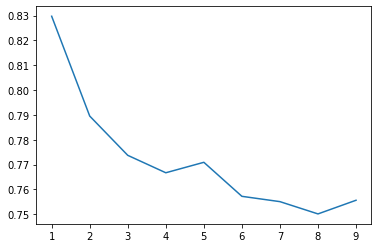

In [36]:
# plot F vs Performance
plt.plot(Fs,mse)

Thus here, we select models with F=6, F=7, F=8.

In [37]:
# final test
F = 6
recommender = RecommenderSystem(F=F,num_users= num_users,num_movies=num_movies)
recommender.train(R_train, epoch=10, batch_size=1000, learning_rate=0.01, penalty=10, verbose=False)
recommender.predict(R_test)

>>>>> Best training error:0.8077541203944635<<<<<<<<<


0.8350288820299465